In [1]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import bson
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
# Define the file path for the mouse logs BSON file
mouse_data_path='D:\mongofiles\data\mydatabase\mouse_logs.bson'

In [3]:
# Function to load multiple BSON objects from a file
def load_multiple_bson_objects(file_path):
    data = []
    with open(file_path, 'rb') as file:
        for document in bson.decode_all(file.read()):
            data.append(document)
    return data


In [4]:
# Load mouse data from the BSON file using the defined function
mouse_data = load_multiple_bson_objects(mouse_data_path)

In [5]:
# Combine mouse data from a list of dictionaries into one DataFrame
data_frames = []

for i in range(len(mouse_data)):
    current_user = mouse_data[i]['user_id']
    current_data_frame = pd.DataFrame(mouse_data[i]['data'])
    current_data_frame['user_id'] = current_user
    data_frames.append(current_data_frame)

mouseData = pd.concat(data_frames, ignore_index=True)
mouseData = mouseData.drop_duplicates()


In [6]:
mouseData['user_id'].unique()

array(['66322d94f89c7cd14b365ea8', '66327fdb321870545078d205',
       '66322d6df89c7cd14b365ea7', '66403324c6d3b6e77f917976'],
      dtype=object)

In [7]:
mouseData['event'].unique()

array(['Move', 'Left Click'], dtype=object)

In [8]:
# Encode 'user_id' and 'event' columns in the mouse data DataFrame
label_encoder = LabelEncoder()
mouseData['user_id'] = label_encoder.fit_transform(mouseData['user_id'])
mouseData['event'] = label_encoder.fit_transform(mouseData['event'])

In [9]:
# Set the 'time' column as the index
mouseData.set_index('time', inplace=True)

In [10]:
# Impute missing values with mean using SimpleImputer
import pandas as pd
from sklearn.impute import SimpleImputer

mouseData.replace('null', pd.NA, inplace=True)

imputer = SimpleImputer(strategy='mean')
mouseData = pd.DataFrame(imputer.fit_transform(mouseData), index=mouseData.index, columns=mouseData.columns)
mouseData.dropna(inplace=True)


In [11]:
# Feature selection and data splitting
features = ['elapsed_time', 'event', 'x', 'y', 'velocity', 'acceleration', 'direction', 'click_duration']
X = mouseData[features]
y = mouseData['user_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.fit_transform(X_test)

In [13]:
y_train.value_counts()

1.0    9424
2.0    1884
0.0     738
3.0     314
Name: user_id, dtype: int64

In [14]:
# Train, Evaluate model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8725331607893886


In [15]:
# Print evaluation metrics

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8725331607893886
Precision: 0.871868664844317
Recall: 0.8725331607893886
F1-score: 0.8602901137497727


In [16]:
# Perform cross-validation
rf_model = RandomForestClassifier()
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5) 
print("Cross-validation scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
rf_model.fit(X_train, y_train)
y_pred_test = rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on Test Set:", accuracy_test)


Cross-validation scores: [0.93406149 0.92718447 0.92556634 0.93244337 0.92961165]
Mean CV Score: 0.9297734627831715
Accuracy on Test Set: 0.8806211582012293


In [17]:
# On the Entire DataSet (i don't do this usually but let's do it for testing)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_scores = cross_val_score(rf_model, X, y, cv=kf)
print("Cross-validation TRIAN scores:", cv_train_scores)
print("Mean CV TRAIN Score:", np.mean(cv_train_scores))

Cross-validation TRIAN scores: [0.94920738 0.93300971 0.92977346 0.93980583 0.94110032]
Mean CV TRAIN Score: 0.9385793393283978


In [18]:
# Lagged features
mouseData['lagged_event'] = mouseData['event'].shift(1)
mouseData['lagged_velocity'] = mouseData['velocity'].shift(1)
mouseData['lagged_acceleration'] = mouseData['acceleration'].shift(1)
mouseData['lagged_direction'] = mouseData['direction'].shift(1)
mouseData['lagged_click_duration'] = mouseData['click_duration'].shift(1)
mouseData['lagged_x'] = mouseData['x'].shift(1)
mouseData['lagged_y'] = mouseData['y'].shift(1)

In [19]:
# Rolling statistics
mouseData['rolling_mean_velocity'] = mouseData['velocity'].rolling(window=5).mean()
mouseData['rolling_mean_acceleration'] = mouseData['acceleration'].rolling(window=5).mean()
mouseData['rolling_mean_click_duration'] = mouseData['click_duration'].rolling(window=5).mean()
mouseData['rolling_mean_x'] = mouseData['x'].rolling(window=5).mean()
mouseData['rolling_mean_y'] = mouseData['y'].rolling(window=5).mean()

In [20]:
#  Seasonal Decomposition
mouseData['trend_velocity'] = mouseData['velocity'].rolling(window=24*60, center=True, min_periods=1).mean()
mouseData['seasonal_velocity'] = mouseData['velocity'] - mouseData['trend_velocity']
mouseData['residual_velocity'] = mouseData['velocity'] - mouseData['trend_velocity'] - mouseData['seasonal_velocity']

In [21]:
plt.figure(figsize=(14, 10))

# Original data
plt.subplot(4, 1, 1)
plt.plot(mouseData.index, mouseData['velocity'], label='Original Velocity')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition')
plt.xlabel('Time')
plt.ylabel('Velocity')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(mouseData.index, mouseData['trend_velocity'], label='Trend Component', color='orange')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Trend')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(mouseData.index, mouseData['seasonal_velocity'], label='Seasonal Component', color='green')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Seasonal')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(mouseData.index, mouseData['residual_velocity'], label='Residual Component', color='red')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

In [22]:
# Convert index to datetime .
mouseData.index = pd.to_datetime(mouseData.index)

In [23]:
# Extract time features.
mouseData.loc[:, 'hour'] = mouseData.index.hour
mouseData.loc[:, 'day_of_week'] = mouseData.index.dayofweek
mouseData.loc[:, 'second'] = mouseData.index.second
mouseData.loc[:, 'millisecond'] = mouseData.index.microsecond // 1000

In [24]:
#Extract  Cyclical Encoding
mouseData['hour_sin'] = np.sin(2 * np.pi * mouseData['hour'] / 24)
mouseData['hour_cos'] = np.cos(2 * np.pi * mouseData['hour'] / 24)
mouseData['day_of_week_sin'] = np.sin(2 * np.pi * mouseData['day_of_week'] / 7)
mouseData['day_of_week_cos'] = np.cos(2 * np.pi * mouseData['day_of_week'] / 7)
mouseData['second_sin'] = np.sin(2 * np.pi * mouseData['second'] / 60)
mouseData['second_cos'] = np.cos(2 * np.pi * mouseData['second'] / 60)
mouseData['millisecond_sin'] = np.sin(2 * np.pi * mouseData['millisecond'] / 1000)
mouseData['millisecond_cos'] = np.cos(2 * np.pi * mouseData['millisecond'] / 1000)
mouseData.drop(columns=['hour', 'day_of_week', 'second', 'millisecond'], inplace=True)

In [25]:
mouseDataCopy=mouseData.copy()

In [26]:
# Build sequences and ensure sequences are user-specific
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mouseData[['elapsed_time', 'x', 'y', 'velocity', 'acceleration', 'direction', 'click_duration',
                                                    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'second_sin', 
                                                    'second_cos', 'millisecond_sin', 'millisecond_cos']])
event_encoder = OneHotEncoder(sparse=False)
event_encoded = event_encoder.fit_transform(mouseData[['event']])
combined_features = np.hstack([scaled_features, event_encoded])

# Reset the index to avoid alignment issues
mouseData.reset_index(drop=True, inplace=True) 
feature_columns = [f'feature_{i}' for i in range(combined_features.shape[1])]
combined_features_df = pd.DataFrame(combined_features, columns=feature_columns)
mouseData = pd.concat([mouseData[['user_id']], combined_features_df], axis=1)
sequence_length = 10

sequences = []
targets = []
sequence_lengths = [] 

seq=0

for user_id, group in mouseData.groupby('user_id'):
    print(f"Preparing sequences for user {user_id}:")
    X_user = group.drop('user_id', axis=1).values  
    for i in range(len(X_user) - sequence_length + 1):
        sequence = X_user[i:i+sequence_length]
        target = user_id  
        sequences.append(sequence)
        targets.append(target)
        seq=seq+1

    print(f"Sequences prepared for user {user_id}: Total sequences for this user = {seq}")
    seq=0


X = np.array(sequences)
y = np.array(targets)



Preparing sequences for user 0.0:
Sequences prepared for user 0.0: Total sequences for this user = 893
Preparing sequences for user 1.0:
Sequences prepared for user 1.0: Total sequences for this user = 11776
Preparing sequences for user 2.0:
Sequences prepared for user 2.0: Total sequences for this user = 2358
Preparing sequences for user 3.0:
Sequences prepared for user 3.0: Total sequences for this user = 388


In [27]:
# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


In [28]:
# Perform Class Balancing
min_samples = min(np.unique(y, return_counts=True)[1])
balanced_X = []
balanced_y = []


for class_label in np.unique(y):
   
    class_samples = X[y == class_label]
    
    sampled_class_data = class_samples[np.random.choice(class_samples.shape[0], min_samples, replace=False)]

    balanced_X.extend(sampled_class_data)
    balanced_y.extend([class_label] * min_samples)
X_balanced = np.array(balanced_X)
y_balanced = np.array(balanced_y)
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1086, 10, 17), y_train shape: (1086,)
X_val shape: (233, 10, 17), y_val shape: (233,)
X_test shape: (233, 10, 17), y_test shape: (233,)


In [29]:
# Iter over the balanced dataset and print sequences with targets
for sequence, target in zip(X_balanced, y_balanced):
    print(f"Target: {target}")
    print("Sequence:")
    print(sequence)
    print("----------------------")


Target: 0.0
Sequence:
[[-0.31931386  0.32973644 -0.20014513 -0.02990081  0.22324029  1.09529962
  -0.07132218  0.25752372  0.74430033 -0.89862496  0.33758237  1.35801289
   0.15438052  0.59562245 -1.26377331  0.          1.        ]
 [-0.31887472  0.30817237 -0.15021428  0.14115406  0.08000316  1.19887618
  -0.06638092  0.25752372  0.74430033 -0.89862496  0.33758237  1.35801289
   0.15438052  0.53077464 -1.29382097  0.          1.        ]
 [-0.31849048  0.28968888 -0.10028343  0.18414246 -0.1814607   1.15645071
  -0.07132218  0.25752372  0.74430033 -0.89862496  0.33758237  1.35801289
   0.15438052  0.47283659 -1.3174521   0.          1.        ]
 [-0.31810623  0.25888307 -0.03370895  0.62833274 -0.22266848  1.2176018
  -0.07132218  0.25752372  0.74430033 -0.89862496  0.33758237  1.35801289
   0.15438052  0.41389939 -1.33855196  0.          1.        ]
 [-0.31772199  0.22191609  0.04118733  0.85384779 -0.68002734  1.23486547
  -0.07132218  0.25752372  0.74430033 -0.89862496  0.33758237

Class 0.0: 274 samples
Class 1.0: 275 samples
Class 2.0: 275 samples
Class 3.0: 262 samples


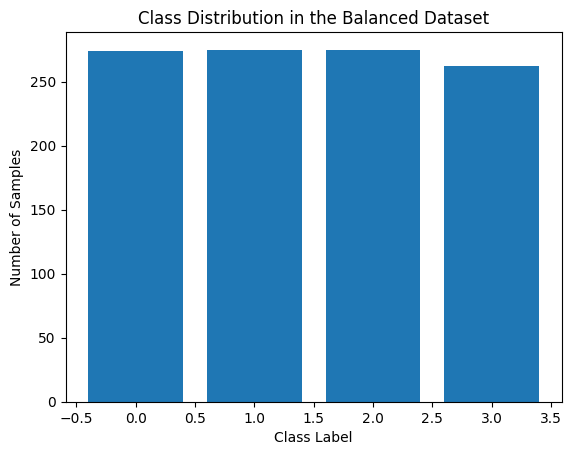

In [30]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")
plt.bar(unique_classes, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Balanced Dataset')
plt.show()

In [31]:
# Determine the balancing ratio
balancing_ratio = mouseData['user_id'].value_counts(normalize=True)
print("Balancing Ratio:")
print(balancing_ratio)

Balancing Ratio:
1.0    0.762734
2.0    0.153194
0.0    0.058378
3.0    0.025694
Name: user_id, dtype: float64


In [32]:
# build model
num_classes = len(np.unique(y_train))

model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
34/34 [==============================] - 12s 90ms/step - loss: 0.9328 - accuracy: 0.6436 - val_loss: 0.5890 - val_accuracy: 0.7296
Epoch 2/20
34/34 [==============================] - 0s 11ms/step - loss: 0.4675 - accuracy: 0.7956 - val_loss: 0.3755 - val_accuracy: 0.8627
Epoch 3/20
34/34 [==============================] - 0s 11ms/step - loss: 0.2718 - accuracy: 0.8978 - val_loss: 0.2395 - val_accuracy: 0.9013
Epoch 4/20
34/34 [==============================] - 0s 13ms/step - loss: 0.1808 - accuracy: 0.9291 - val_loss: 0.1803 - val_accuracy: 0.9099
Epoch 5/20
34/34 [==============================] - 2s 52ms/step - loss: 0.1007 - accuracy: 0.9678 - val_loss: 0.0610 - val_accuracy: 0.9742
Epoch 6/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0513 - accuracy: 0.9843 - val_loss: 0.0335 - val_accuracy: 0.9914
Epoch 7/20
34/34 [==============================] - 0s 10ms/step - loss: 0.0299 - accuracy: 0.9926 - val_loss: 0.0475 - val_accuracy: 0.9871
Epoch 8/20
3

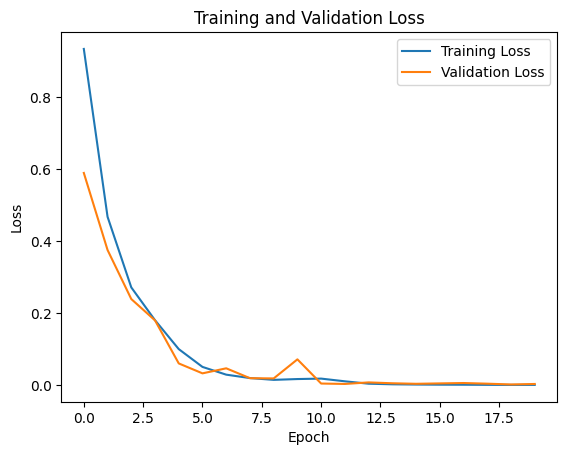

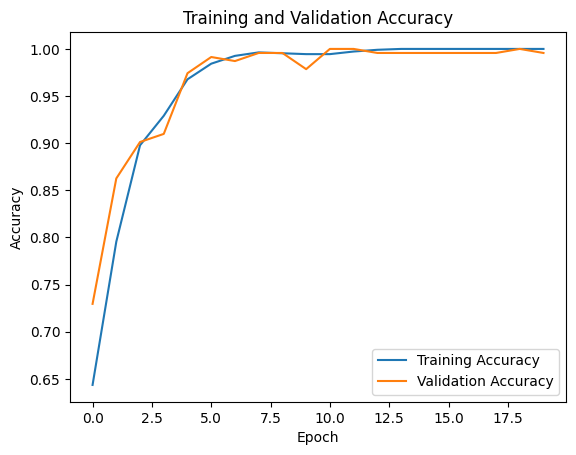

In [33]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [34]:
# Define the function to create the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # Number of classes dynamically determined

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


n_folds = 5
cv_scores = []

kf = KFold(n_splits=n_folds, shuffle=True)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

 
    model = create_lstm_model()

    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(accuracy)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.9954128265380859, 0.9953917264938354, 0.9907833933830261, 0.9861751198768616, 0.9953917264938354]
Mean CV Score: 0.9926309585571289


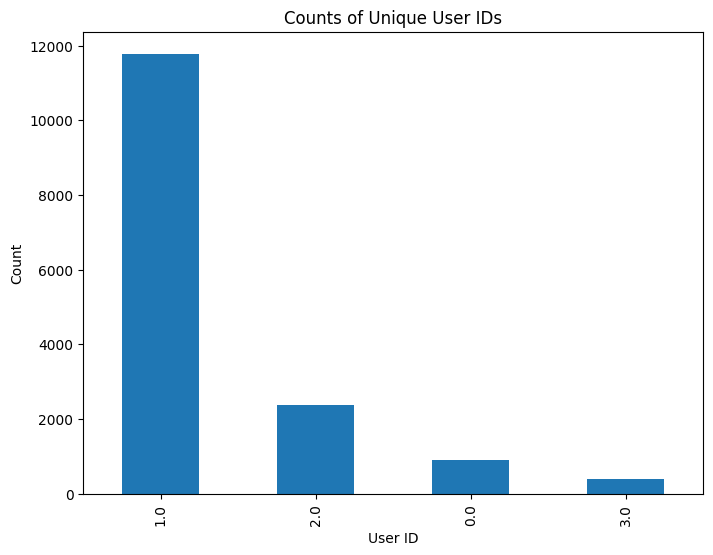

In [35]:
user_counts = mouseData['user_id'].value_counts()
plt.figure(figsize=(8, 6))
user_counts.plot(kind='bar')
plt.title('Counts of Unique User IDs')
plt.xlabel('User ID')
plt.ylabel('Count')
plt.show()

In [41]:
mouseDataCopy.columns

Index(['elapsed_time', 'event', 'x', 'y', 'velocity', 'acceleration',
       'direction', 'click_duration', 'user_id', 'lagged_event',
       'lagged_velocity', 'lagged_acceleration', 'lagged_direction',
       'lagged_click_duration', 'lagged_x', 'lagged_y',
       'rolling_mean_velocity', 'rolling_mean_acceleration',
       'rolling_mean_click_duration', 'rolling_mean_x', 'rolling_mean_y',
       'trend_velocity', 'seasonal_velocity', 'residual_velocity', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'second_sin',
       'second_cos', 'millisecond_sin', 'millisecond_cos'],
      dtype='object')

In [59]:
X = mouseDataCopy[['elapsed_time', 'event', 'x', 'y', 'velocity', 'acceleration',
       'direction', 'click_duration', 'lagged_event',
       'lagged_velocity', 'lagged_acceleration', 'lagged_direction',
       'lagged_click_duration', 'lagged_x', 'lagged_y',
       'rolling_mean_velocity', 'rolling_mean_acceleration',
       'rolling_mean_click_duration', 'rolling_mean_x', 'rolling_mean_y',
       'trend_velocity', 'seasonal_velocity', 'residual_velocity', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'second_sin',
       'second_cos', 'millisecond_sin', 'millisecond_cos']]  # Features
y = mouseDataCopy['user_id']  # Target
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [60]:
X.columns

Index(['elapsed_time', 'event', 'x', 'y', 'velocity', 'acceleration',
       'direction', 'click_duration', 'lagged_event', 'lagged_velocity',
       'lagged_acceleration', 'lagged_direction', 'lagged_click_duration',
       'lagged_x', 'lagged_y', 'rolling_mean_velocity',
       'rolling_mean_acceleration', 'rolling_mean_click_duration',
       'rolling_mean_x', 'rolling_mean_y', 'trend_velocity',
       'seasonal_velocity', 'residual_velocity', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'second_sin', 'second_cos',
       'millisecond_sin', 'millisecond_cos'],
      dtype='object')

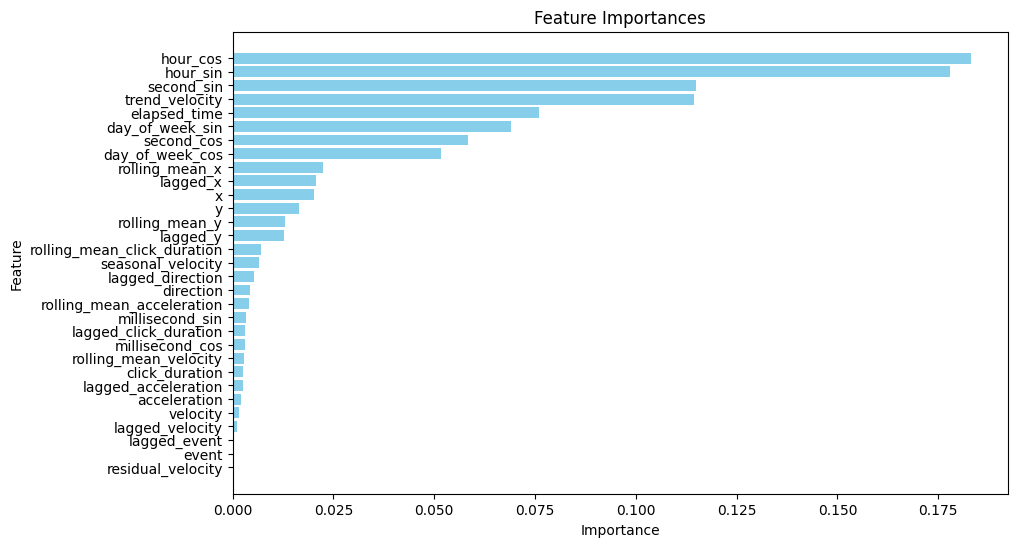

In [61]:
pipeline.fit(X, y)
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

# now i have preview about the features and i can figure out what features to choose with real world data .

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

F1 Score: 1.0
Confusion Matrix:
[[ 164    0    0    0]
 [   0 2361    0    0]
 [   0    0  483    0]
 [   0    0    0   83]]


In [63]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5) 
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [1.         0.99959547 1.         1.         1.        ]
Mean CV Score: 0.9999190938511326
